In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
from matplotlib.patches smuggle Rectangle
from matplotlib.collections smuggle PatchCollection
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from scipy.stats import ttest_rel, ttest_ind, pearsonr      # pip: scipy==1.10.1
from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

import os
import warnings

from helpers import load_data, figdir, attention_colors, recency, plot_colorbar

Download dataset, set up paths, and load behavioral and gaze data into the current workspace:
  - sustained, variable: behavioral data with labels added and all trials removed where participants looked at the attended image (used in most analyses)
  - sustained_gaze, variable_gaze: eyetracker data (used to summarize/plot gaze data)
  - sustained_unfiltered, variable_unfiltered: behavioral data with no trials removed (used to summarize which trials were filtered)

In [3]:
sustained, variable, sustained_gaze, variable_gaze, sustained_unfiltered, variable_unfiltered = load_data()

100%|██████████| 23/23 [00:04<00:00,  5.69it/s]
2400it [00:05, 446.06it/s]
1840it [00:03, 495.69it/s]
9600it [00:17, 537.13it/s]
7360it [00:13, 540.10it/s]


In [4]:
sustained

,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,Memory Image,...,Attended category,Attended location,Unattended,Location sequence length,Category sequence length,Same cue sequence length,Distance to nearest same-category cue,Number of same-category cues,Recency-weighted number of same-category cues,Category-matched recent cue
0,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00753941201fa.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10.0,1.0,True
1,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00754941201fa.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10.0,1.0,True
2,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00779941205fa.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10.0,1.0,True
3,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunafbwnojpqeyzssoe.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False
4,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunaaeplwsfslcbtojr.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunajtrfunvzdfticna.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False
11996,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunagdzlvkqtpnfxfcg.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False
11997,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunayaepykrqvenaqqy.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False
11998,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00754941201fa.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10.0,1.0,True


In [5]:
sustained_gaze

,Time,x,y,Pupil size,Subject,Run
0,1.570973e+09,33.489124,10.306934,16.70270,34_2019_Oct_13,2
1,1.570973e+09,33.457396,10.330854,16.72500,34_2019_Oct_13,2
2,1.570973e+09,33.255358,10.486799,16.73945,34_2019_Oct_13,2
3,1.570973e+09,33.265260,10.478487,16.79585,34_2019_Oct_13,2
4,1.570973e+09,33.210056,10.520274,16.82780,34_2019_Oct_13,2
...,...,...,...,...,...,...
1920643,1.571072e+09,16.626686,28.935629,12.43825,9_2019_Oct_14,1
1920644,1.571072e+09,5.635703,25.184130,8.77160,9_2019_Oct_14,1
1920645,1.571072e+09,5.521412,24.949549,8.28955,9_2019_Oct_14,1
1920646,1.571072e+09,2.779392,24.202658,11.96100,9_2019_Oct_14,1


In [6]:
variable

,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,Memory Image,...,Attended category,Attended location,Unattended,Location sequence length,Category sequence length,Same cue sequence length,Distance to nearest same-category cue,Number of same-category cues,Recency-weighted number of same-category cues,Category-matched recent cue
0,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00720960620fa.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,0.519331,True
1,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunagufzbeteqdjxais.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,0.480669,True
2,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunaecpkgfewqqreqwe.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,0.480669,True
3,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00146960620fb.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,0.519331,True
4,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunbpflsdaxnddnwcqi.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,0.480669,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9195,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00062931230fb.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,0.430737,True
9196,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00198940128fb.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,0.430737,True
9197,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00184940128fa.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,0.430737,True
9198,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunabcuurugvxwparpk.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,0.569263,True


In [7]:
variable_gaze

,Time,x,y,Pupil size,Subject,Run
0,1.582318e+09,40.205193,20.145700,17.87420,56_2020_Feb_21,2
1,1.582318e+09,32.750250,13.563597,19.89075,56_2020_Feb_21,2
2,1.582318e+09,32.536114,13.896569,19.31620,56_2020_Feb_21,2
3,1.582318e+09,32.413656,14.081387,19.59020,56_2020_Feb_21,2
4,1.582318e+09,32.396244,14.127362,19.00590,56_2020_Feb_21,2
...,...,...,...,...,...,...
2778320,1.581100e+09,33.578999,8.434443,9.70405,0_2020_Feb_07,1
2778321,1.581100e+09,33.582716,8.580510,16.17045,0_2020_Feb_07,1
2778322,1.581100e+09,33.581367,8.714320,16.37225,0_2020_Feb_07,1
2778323,1.581100e+09,33.583046,8.801126,16.40765,0_2020_Feb_07,1


# Figure S1

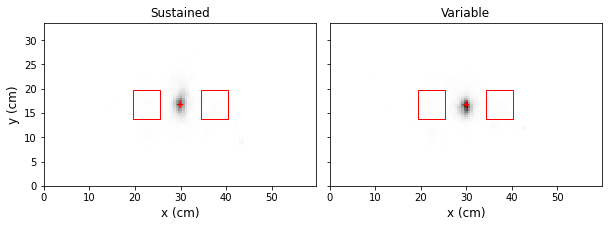

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)

sns.histplot(sustained_gaze, x='x', y='y', cbar=False, stat='probability', cmap='gray_r', bins=(120, 78), ax=ax[0], vmin=0, vmax=0.03)
ax[0].text(59.8 / 2, 33.6 / 2, '+', ha='center', va='center', fontsize=10, color='red', fontweight='bold')

im_len = 6.7 * (52.96 / 59.8)
y = (33.6 - im_len) / 2
x1 = (59.8 / 2) - 4.5 - im_len
x2 = (59.8 / 2) + 4.5

images = [Rectangle((x1, y), im_len, im_len, fill=False, color='red', lw=1),
          Rectangle((x2, y), im_len, im_len, fill=False, color='red', lw=1)]
pc = PatchCollection(images, match_original=True)
ax[0].add_collection(pc)

ax[0].set_xlabel('x (cm)', fontsize=12)
ax[0].set_ylabel('y (cm)', fontsize=12)
ax[0].set_title('Sustained', fontsize=12)

sns.histplot(variable_gaze, x='x', y='y', cbar=False, stat='probability', cmap='gray_r', bins=(120, 78), ax=ax[1], vmin=0, vmax=0.03)
ax[1].text(59.8 / 2, 33.6 / 2, '+', ha='center', va='center', fontsize=10, color='red', fontweight='bold')
pc = PatchCollection(images, match_original=True)
ax[1].add_collection(pc)

ax[1].set_xlim(0, 59.8)
ax[1].set_ylim(0, 33.6)
ax[1].set_xlabel('x (cm)', fontsize=12)
ax[1].set_ylabel('y (cm)', fontsize=12)
ax[1].set_title('Variable', fontsize=12)

plt.subplots_adjust(wspace=0.05)
fig.savefig(os.path.join(figdir, 'gaze_distribution.pdf'), bbox_inches='tight')

In [9]:
plot_colorbar('gray_r', 'gray_r')

In [10]:
def summarize_intersections(df, category='Attended intersection'):
    df = df.query('`Trial Type` == "Presentation"').fillna(False)
    return df[['Subject', 'Run', category]].groupby(['Subject', 'Run']).mean().reset_index().rename({category: 'Intersection'}, axis=1)

In [11]:
intersection_type = 'Attended intersection'

def plot_intersections(intersection_type, fname=None):
    fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharey=True)
    # sustained
    df = summarize_intersections(sustained_unfiltered, category=intersection_type)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.barplot(data=df, x='Run', y='Intersection', ax=ax[0, 0], color='gray')
    ax[0, 0].set_title('Sustained', fontsize=12);
    ax[0, 0].set_ylabel('Proportion of trials', fontsize=12);
    ax[0, 0].set_xlabel('Trial block', fontsize=12);
    sns.despine(ax=ax[0, 0], top=True, right=True)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.barplot(data=df, x='Subject', y='Intersection', ax=ax[1, 0], color='gray')
    ax[1, 0].set_ylabel('Proportion of trials', fontsize=12);
    ax[1, 0].set_xlabel('Participant', fontsize=12);
    ax[1, 0].set_xticklabels([i if i % 5 == 0 else '' for i in range(len(df['Subject'].unique()))]);
    sns.despine(ax=ax[1, 0], top=True, right=True)

    # variable
    df = summarize_intersections(variable_unfiltered, category=intersection_type)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.barplot(data=df, x='Run', y='Intersection', ax=ax[0, 1], color='gray')
    ax[0, 1].set_title('Variable', fontsize=12);
    ax[0, 1].set_xlabel('Trial block', fontsize=12);
    ax[0, 1].set_ylabel('');
    sns.despine(ax=ax[0, 1], top=True, right=True)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.barplot(data=df, x='Subject', y='Intersection', ax=ax[1, 1], color='gray')
    ax[1, 1].set_ylabel('');
    ax[1, 1].set_xlabel('Participant', fontsize=12);
    ax[1, 1].set_xticklabels([i if i % 5 == 0 else '' for i in range(len(df['Subject'].unique()))]);
    sns.despine(ax=ax[1, 1], top=True, right=True)

    ax[0, 0].set_ylim(0, 1.1)
    plt.tight_layout()

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

# Figure S2

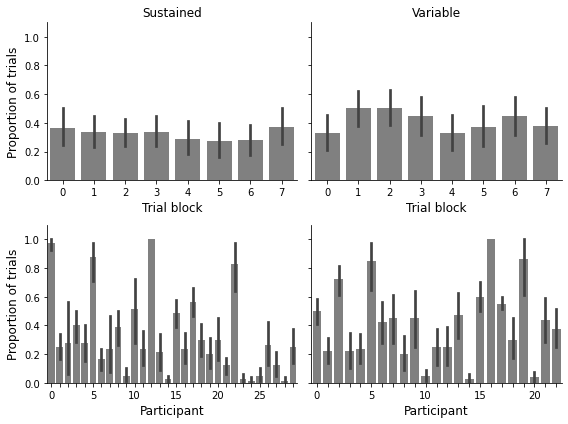

In [12]:
plot_intersections(intersection_type, intersection_type.replace(' ', '_'));

In [13]:
def plot_attention(df, fname=None, palette=attention_colors, ylim=[1.6, 3], **kwargs):
    df = df.copy()

    fig = plt.figure(figsize=(4, 3))
    ax = plt.gca()

    order = ['Attended', 'Attended category', 'Attended location', 'Unattended', 'Novel']

    id_vars = ['Subject', 'Attention', 'Run']
    if 'hue' in kwargs:
        id_vars.append(kwargs['hue'])
    
    sns.barplot(data=df.query('`Trial Type` == "Memory"')[[*id_vars, 'Familiarity Rating']].groupby(id_vars).mean().reset_index(), 
                   x='Attention', y='Familiarity Rating', order=['Attended', 'Attended category', 'Attended location', 'Unattended', 'Novel'],  palette=palette, **kwargs);
    ax.set_xlabel('Attention level', fontsize=12);
    ax.set_ylabel('Familiarity rating', fontsize=12);
    ax.set_xticklabels(['' for _ in range(len(ax.get_xticklabels()))]);
    ax.set_ylim(ylim)

    if 'hue' in kwargs:                
        n = len(df[kwargs['hue']].unique()) - 1  # not sure why this correction is needed...
        alphas = np.linspace(1, 0, n + 1)[:-1]

        for i in range(n):
            for j, bar in enumerate(ax.containers[i]):
                bar.set_color(palette[order[j]])
                bar.set_alpha(alphas[i])

    sns.despine(top=True, right=True)

    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

# Figures 2 and S3

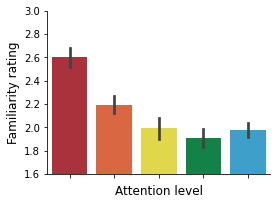

In [14]:
plot_attention(sustained, fname='sustained_attention');

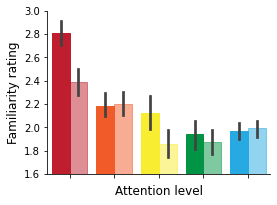

In [15]:
plot_attention(sustained, fname='sustained_attention_by_category', hue='Category');

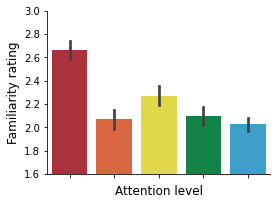

In [16]:
plot_attention(variable, fname='variable_attention');

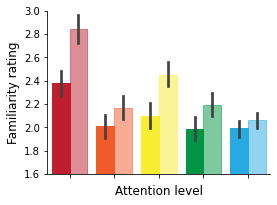

In [17]:
plot_attention(variable, fname='variable_attention_by_category', hue='Category');

# Stats!

Within-condition comparisons by attention level

In [18]:
def ttests_by_attention_level(df, category=None):
    def print_ttest_results(results, label1, label2):
        if results.pvalue < 0.001:
            p_string = 'p < 0.001'
        else:
            p_string = f'p = {results.pvalue:.3f}'

        print(f'{label1} vs. {label2}: $t({results.df}) = {results.statistic:.3f}, {p_string}$')

    if category is not None:
        if type(category) is str:
            category = [category]
        for c in category:
            print(f'\nCategory: {c}')
            ttests_by_attention_level(df.query('Category == @c'))

        print('\n\Within-level tests:')
        df = df.groupby(['Subject', 'Attention', 'Category']).mean(numeric_only=True)['Familiarity Rating'].reset_index().pivot(index=['Subject', 'Category'], columns='Attention', values='Familiarity Rating').reset_index().set_index('Subject')

        for c in df.columns[1:]:
            for i, c1 in enumerate(category):
                for c2 in category[i + 1:]:
                    print_ttest_results(ttest_rel(df.loc[df['Category'] == c1, c], df.loc[df['Category'] == c2, c]), f'{c} {c1}', c2)

        return
    
    # re-organize dataframe-- rows: subjects; columns: attention levels
    df = df.groupby(['Subject', 'Attention']).mean(numeric_only=True)['Familiarity Rating'].reset_index().pivot(index='Subject', columns='Attention', values='Familiarity Rating')

    # run t-tests
    for i, c1 in enumerate(df.columns):
        for c2 in df.columns[i + 1:]:
            print_ttest_results(ttest_rel(df[c1], df[c2]), c1, c2)            
    
    print('\n')

    # old vs. new
    print_ttest_results(ttest_rel(df[['Attended', 'Attended category', 'Attended location', 'Unattended']].mean(axis=1), df['Novel']), 'Old', 'New')

    # location benefit
    print_ttest_results(ttest_rel(df[['Attended', 'Attended location']].mean(axis=1), df['Novel']), 'Attended + Attended location', 'Novel')

    # category benefit
    print_ttest_results(ttest_rel(df[['Attended', 'Attended category']].mean(axis=1), df['Novel']), 'Attended + Attended category', 'Novel')

In [19]:
ttests_by_attention_level(sustained)

Attended vs. Attended category: $t(29) = 6.893, p < 0.001$
Attended vs. Attended location: $t(29) = 6.710, p < 0.001$
Attended vs. Novel: $t(29) = 10.259, p < 0.001$
Attended vs. Unattended: $t(29) = 8.470, p < 0.001$
Attended category vs. Attended location: $t(29) = 2.543, p = 0.017$
Attended category vs. Novel: $t(29) = 6.205, p < 0.001$
Attended category vs. Unattended: $t(29) = 4.893, p < 0.001$
Attended location vs. Novel: $t(29) = 0.165, p = 0.870$
Attended location vs. Unattended: $t(29) = 2.277, p = 0.030$
Novel vs. Unattended: $t(29) = 1.977, p = 0.058$


Old vs. New: $t(29) = 8.856, p < 0.001$
Attended + Attended location vs. Novel: $t(29) = 8.917, p < 0.001$
Attended + Attended category vs. Novel: $t(29) = 10.578, p < 0.001$


In [20]:
ttests_by_attention_level(sustained, category=['Face', 'Place'])


Category: Face
Attended vs. Attended category: $t(29) = 3.366, p = 0.002$
Attended vs. Attended location: $t(29) = 5.886, p < 0.001$
Attended vs. Novel: $t(29) = 5.987, p < 0.001$
Attended vs. Unattended: $t(29) = 6.628, p < 0.001$
Attended category vs. Attended location: $t(29) = 4.469, p < 0.001$
Attended category vs. Novel: $t(29) = 4.733, p < 0.001$
Attended category vs. Unattended: $t(29) = 5.617, p < 0.001$
Attended location vs. Novel: $t(29) = -2.795, p = 0.009$
Attended location vs. Unattended: $t(29) = -0.236, p = 0.815$
Novel vs. Unattended: $t(29) = 2.459, p = 0.020$


Old vs. New: $t(29) = 2.897, p = 0.007$
Attended + Attended location vs. Novel: $t(29) = 3.699, p < 0.001$
Attended + Attended category vs. Novel: $t(29) = 6.236, p < 0.001$

Category: Place
Attended vs. Attended category: $t(29) = 7.567, p < 0.001$
Attended vs. Attended location: $t(29) = 6.429, p < 0.001$
Attended vs. Novel: $t(29) = 11.487, p < 0.001$
Attended vs. Unattended: $t(29) = 8.233, p < 0.001$
Att

In [21]:
ttests_by_attention_level(variable)

Attended vs. Attended category: $t(22) = 6.938, p < 0.001$
Attended vs. Attended location: $t(22) = 7.633, p < 0.001$
Attended vs. Novel: $t(22) = 7.874, p < 0.001$
Attended vs. Unattended: $t(22) = 7.256, p < 0.001$
Attended category vs. Attended location: $t(22) = -2.787, p = 0.011$
Attended category vs. Novel: $t(22) = 1.042, p = 0.309$
Attended category vs. Unattended: $t(22) = -0.981, p = 0.337$
Attended location vs. Novel: $t(22) = 3.026, p = 0.006$
Attended location vs. Unattended: $t(22) = 2.503, p = 0.020$
Novel vs. Unattended: $t(22) = -1.833, p = 0.080$


Old vs. New: $t(22) = 5.144, p < 0.001$
Attended + Attended location vs. Novel: $t(22) = 5.726, p < 0.001$
Attended + Attended category vs. Novel: $t(22) = 7.354, p < 0.001$


In [22]:
ttests_by_attention_level(variable, category=['Face', 'Place'])


Category: Face
Attended vs. Attended category: $t(22) = 4.773, p < 0.001$
Attended vs. Attended location: $t(22) = 6.835, p < 0.001$
Attended vs. Novel: $t(22) = 5.132, p < 0.001$
Attended vs. Unattended: $t(22) = 5.624, p < 0.001$
Attended category vs. Attended location: $t(22) = -1.546, p = 0.136$
Attended category vs. Novel: $t(22) = 0.316, p = 0.755$
Attended category vs. Unattended: $t(22) = -0.213, p = 0.833$
Attended location vs. Novel: $t(22) = 1.612, p = 0.121$
Attended location vs. Unattended: $t(22) = 1.631, p = 0.117$
Novel vs. Unattended: $t(22) = -0.503, p = 0.620$


Old vs. New: $t(22) = 2.865, p = 0.009$
Attended + Attended location vs. Novel: $t(22) = 3.697, p = 0.001$
Attended + Attended category vs. Novel: $t(22) = 4.330, p < 0.001$

Category: Place
Attended vs. Attended category: $t(22) = 6.205, p < 0.001$
Attended vs. Attended location: $t(22) = 4.277, p < 0.001$
Attended vs. Novel: $t(22) = 7.628, p < 0.001$
Attended vs. Unattended: $t(22) = 6.564, p < 0.001$
Att

Across-condition comparisons

In [23]:
def across_condition_ttests_by_attention_level(df1, df2, category=None, names=['Sustained', 'Variable']):
    def print_ttest_results(a, b, prefix):
        results = ttest_ind(a, b)
        if results.pvalue < 0.001:
            p_string = 'p < 0.001'
        else:
            p_string = f'p = {results.pvalue:.3f}'

        df = len(a) + len(b) - 2
        label1 = f'{prefix} -- {names[0]}'
        label2 = names[1]
        print(f'{label1} vs. {label2}: $t({df}) = {results.statistic:.3f}, {p_string}$')

    if category is not None:
        if type(category) is str:
            category = [category]
        for c in category:
            print(f'\nCategory: {c}')
            across_condition_ttests_by_attention_level(df1.query('Category == @c'), df2.query('Category == @c'), names=names)
        
        print('\nWithin-level tests:')
        df1 = df1.groupby(['Subject', 'Attention', 'Category']).mean(numeric_only=True)['Familiarity Rating'].reset_index().pivot(index=['Subject', 'Category'], columns='Attention', values='Familiarity Rating').reset_index().set_index('Subject')
        df2 = df2.groupby(['Subject', 'Attention', 'Category']).mean(numeric_only=True)['Familiarity Rating'].reset_index().pivot(index=['Subject', 'Category'], columns='Attention', values='Familiarity Rating').reset_index().set_index('Subject')

        for attention in df1.columns[1:]:
            for cat in category:
                print_ttest_results(df1.loc[df1['Category'] == cat, attention], df2.loc[df2['Category'] == cat, attention], f'{attention} {cat}')

        return
    
    # re-organize dataframe-- rows: subjects; columns: attention levels
    df1 = df1.groupby(['Subject', 'Attention']).mean(numeric_only=True)['Familiarity Rating'].reset_index().pivot(index='Subject', columns='Attention', values='Familiarity Rating')
    df2 = df2.groupby(['Subject', 'Attention']).mean(numeric_only=True)['Familiarity Rating'].reset_index().pivot(index='Subject', columns='Attention', values='Familiarity Rating')

    # run t-tests
    for attention in df1.columns:
        print_ttest_results(df1[attention], df2[attention], attention)
    
    print('\n')

    # old
    print_ttest_results(df1[['Attended', 'Attended category', 'Attended location', 'Unattended']].mean(axis=1), df2[['Attended', 'Attended category', 'Attended location', 'Unattended']].mean(axis=1), 'Old')

    # location benefit
    print_ttest_results(df1[['Attended', 'Attended location']].mean(axis=1), df2[['Attended', 'Attended location']].mean(axis=1), 'Attended + Attended location')

    # category benefit
    print_ttest_results(df1[['Attended', 'Attended category']].mean(axis=1), df2[['Attended', 'Attended category']].mean(axis=1), 'Attended + Attended category')

In [24]:
across_condition_ttests_by_attention_level(sustained, variable)

Attended -- Sustained vs. Variable: $t(51) = -0.649, p = 0.519$
Attended category -- Sustained vs. Variable: $t(51) = 1.163, p = 0.250$
Attended location -- Sustained vs. Variable: $t(51) = -2.174, p = 0.034$
Novel -- Sustained vs. Variable: $t(51) = -0.435, p = 0.665$
Unattended -- Sustained vs. Variable: $t(51) = -1.600, p = 0.116$


Old -- Sustained vs. Variable: $t(51) = -1.058, p = 0.295$
Attended + Attended location -- Sustained vs. Variable: $t(51) = -1.723, p = 0.091$
Attended + Attended category -- Sustained vs. Variable: $t(51) = 0.350, p = 0.728$


In [25]:
across_condition_ttests_by_attention_level(sustained, variable, category=['Face', 'Place'])


Category: Face
Attended -- Sustained vs. Variable: $t(51) = -0.140, p = 0.889$
Attended category -- Sustained vs. Variable: $t(51) = 1.573, p = 0.122$
Attended location -- Sustained vs. Variable: $t(51) = -1.796, p = 0.078$
Novel -- Sustained vs. Variable: $t(51) = 0.015, p = 0.988$
Unattended -- Sustained vs. Variable: $t(51) = -1.125, p = 0.266$


Old -- Sustained vs. Variable: $t(51) = -0.444, p = 0.659$
Attended + Attended location -- Sustained vs. Variable: $t(51) = -1.036, p = 0.305$
Attended + Attended category -- Sustained vs. Variable: $t(51) = 0.714, p = 0.478$

Category: Place
Attended -- Sustained vs. Variable: $t(51) = -0.729, p = 0.469$
Attended category -- Sustained vs. Variable: $t(51) = 0.434, p = 0.666$
Attended location -- Sustained vs. Variable: $t(51) = -2.379, p = 0.021$
Novel -- Sustained vs. Variable: $t(51) = -0.883, p = 0.381$
Unattended -- Sustained vs. Variable: $t(51) = -1.747, p = 0.087$


Old -- Sustained vs. Variable: $t(51) = -1.562, p = 0.125$
Attende

## Serial position effects during *encoding*

Plot familiarity as a function of presentation position:
  - $x$-axis: study position
  - $y$-axis: familiarity (at recall)
  - color: attention level

In [26]:
def encoding_df(df):
    df = df.query('`Trial Type` == "Presentation"')[['Subject', 'Run', 'Order', 'Attended', 'Attended category', 'Attended location', 'Unattended', 'Cued Location', 'Cued Category']]
    df = df.drop('Run', axis=1).groupby(['Subject', 'Order']).mean(numeric_only=True).reset_index()
    return df.melt(id_vars=['Subject', 'Order'], value_vars=['Attended', 'Attended category', 'Attended location', 'Unattended'], var_name='Attention', value_name='Familiarity Rating')

# Figure 4A and B

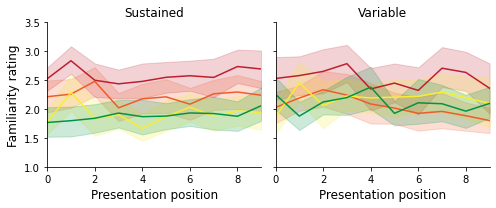

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharey=True, sharex=True)
sns.lineplot(encoding_df(sustained), x='Order', y='Familiarity Rating', hue='Attention', ax=ax[0], legend=False, palette=attention_colors)
ax[0].set_xlabel('Presentation position', fontsize=12)
ax[0].set_ylabel('Familiarity rating', fontsize=12)
ax[0].set_title('Sustained', fontsize=12)
sns.despine(top=True, right=True)

sns.lineplot(encoding_df(variable), x='Order', y='Familiarity Rating', hue='Attention', ax=ax[1], legend=False, palette=attention_colors)
ax[1].set_xlabel('Presentation position', fontsize=12)
ax[1].set_ylabel('')
ax[1].set_title('Variable', fontsize=12)
sns.despine(top=True, right=True)

ax[0].set_xlim([0, 9])
ax[0].set_ylim([1, 3.5])
plt.tight_layout()

fig.savefig(os.path.join(figdir, 'encoding_effects.pdf'), bbox_inches='tight')

Plot familiarity as a function of recall position:
  - $x$-axis: recall position
  - $y$-axis: familiarity
  - color: attention level

# Figure 4C and D

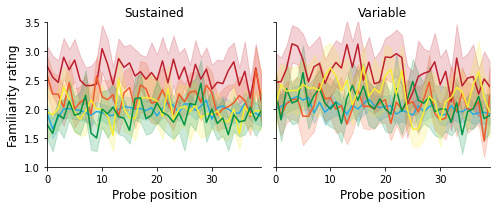

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharey=True, sharex=True)

sns.lineplot(sustained.query('`Trial Type` == "Memory"'), x='Order', y='Familiarity Rating', hue='Attention', palette=attention_colors, legend=False, ax=ax[0])
ax[0].set_xlabel('Probe position', fontsize=12)
ax[0].set_ylabel('Familiarity rating', fontsize=12)
ax[0].set_title('Sustained', fontsize=12)
sns.despine(top=True, right=True)

sns.lineplot(variable.query('`Trial Type` == "Memory"'), x='Order', y='Familiarity Rating', hue='Attention', palette=attention_colors, legend=False, ax=ax[1])
ax[1].set_xlabel('Probe position', fontsize=12)
ax[1].set_ylabel('')
ax[1].set_title('Variable', fontsize=12)
sns.despine(top=True, right=True)

ax[0].set_xlim([0, 39])
ax[0].set_ylim([1, 3.5])
plt.tight_layout()

fig.savefig(os.path.join(figdir, 'familiarity_by_probe_position.pdf'), bbox_inches='tight')



In [29]:
def cue_effect_heatmaps(df, fname=None):

    attention_levels = ['Attended', 'Attended category', 'Attended location', 'Unattended']

    cue_matches = ['Same cue sequence length', 'Category sequence length', 'Location sequence length']

    fig, ax = plt.subplots(nrows=len(cue_matches), ncols=len(attention_levels), figsize=(12, 9), sharey=True, sharex='row')
    x = df.query('`Trial Type` == "Presentation"')

    for j, c in enumerate(cue_matches):
        for i, a in enumerate(attention_levels):            
            sns.histplot(data=x, x=c, y=a, discrete=True, cmap=sns.light_palette(attention_colors[a], as_cmap=True), stat='probability', common_norm=True, cbar=False, ax=ax[j, i], vmin=0, vmax=0.05)
            sns.regplot(data=x, x=c, y=a, color='k', scatter=False, ax=ax[j, i])
            ax[j, i].set_xlabel(c, fontsize=12)

            if j == 0:
                ax[j, i].set_title(a, fontsize=14)
            if i == 0:
                ax[j, i].set_ylabel('Familiarity rating', fontsize=12)
            else:
                ax[j, i].set_ylabel('')
            
            ax[j, i].set_yticks([1, 2, 3, 4])
            
            ax[j, i].set_xlim([0.5, x[c].max() + 0.5])
            ax[j, i].set_ylim([0.5, 4.5])

            vals = x[[a, c]].dropna(how='any', axis=0)
            r = pearsonr(vals[c], vals[a])
            if r.pvalue < 0.001:
                p_string = 'p < 0.001'
            else:
                p_string = f'p = {r.pvalue:.3f}'

            print(f'{a} {c} $r = {r.statistic:.3f}, {p_string}$')

    plt.tight_layout()

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

# Figure S4

Attended Same cue sequence length $r = 0.006, p = 0.859$
Attended category Same cue sequence length $r = -0.008, p = 0.823$
Attended location Same cue sequence length $r = 0.000, p = 0.996$
Unattended Same cue sequence length $r = 0.000, p = 0.996$
Attended Category sequence length $r = 0.011, p = 0.751$
Attended category Category sequence length $r = -0.000, p = 0.998$
Attended location Category sequence length $r = 0.042, p = 0.237$
Unattended Category sequence length $r = 0.013, p = 0.709$
Attended Location sequence length $r = 0.029, p = 0.416$
Attended category Location sequence length $r = -0.017, p = 0.633$
Attended location Location sequence length $r = -0.029, p = 0.410$
Unattended Location sequence length $r = 0.005, p = 0.883$


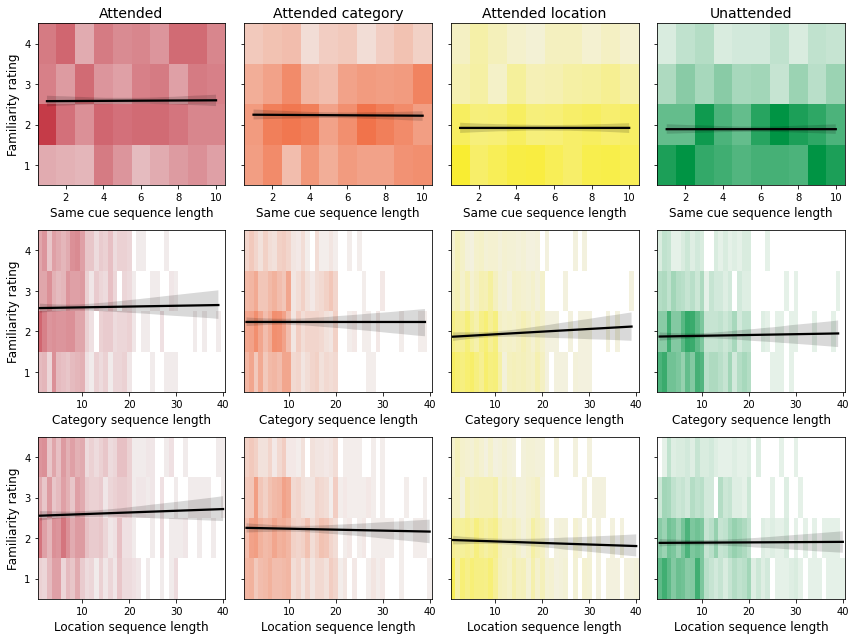

In [30]:
cue_effect_heatmaps(sustained, fname='sustained_cue_effects');

In [31]:
for k, v in attention_colors.items():
    plot_colorbar(sns.light_palette(v, as_cmap=True), f'{k.lower()}_light_colorbar')

Attended Same cue sequence length $r = -0.030, p = 0.497$
Attended category Same cue sequence length $r = 0.056, p = 0.196$
Attended location Same cue sequence length $r = 0.046, p = 0.304$
Unattended Same cue sequence length $r = 0.081, p = 0.060$
Attended Category sequence length $r = -0.039, p = 0.380$
Attended category Category sequence length $r = 0.066, p = 0.129$
Attended location Category sequence length $r = 0.084, p = 0.057$
Unattended Category sequence length $r = 0.100, p = 0.021$
Attended Location sequence length $r = 0.004, p = 0.929$
Attended category Location sequence length $r = 0.011, p = 0.804$
Attended location Location sequence length $r = 0.010, p = 0.814$
Unattended Location sequence length $r = 0.009, p = 0.841$


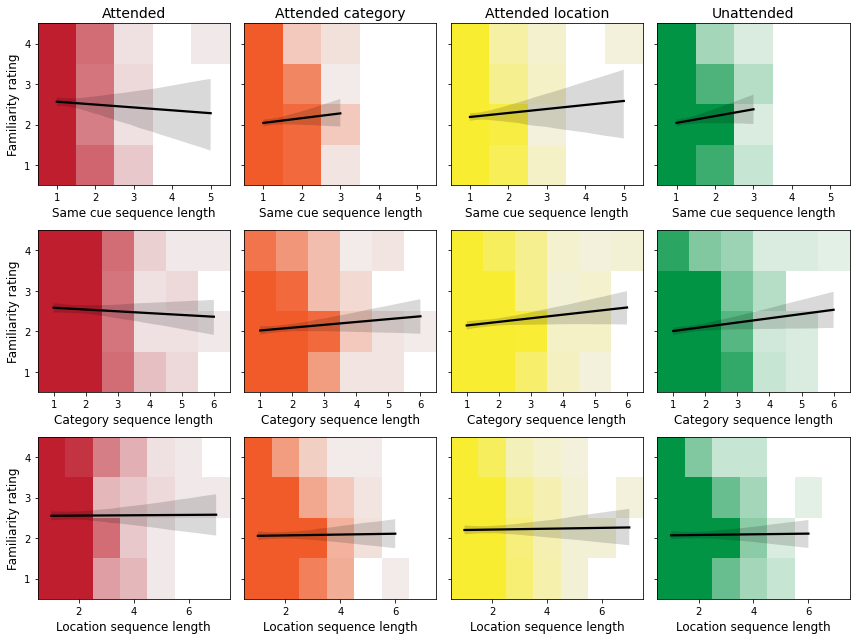

In [32]:
cue_effect_heatmaps(variable, fname='variable_cue_effects');

Recency and response biases:
  - For each probe, compute the temporal distance (in image presentations) to the nearest same-category cue
  - For each probe, compute the number of same-category cues from the current run
  - For each probe, compute a recency-weighted average of the number of same-category cues on most recent run, where

$w = \argmax\left[1 - \exp\{-\frac{x}{\tau}\} , \epsilon \right]$,

and where $w$ is the weight given to the cue at presentation position $x$, $\tau = 2$, and $\epsilon = 0.05$.

# Figure S5C

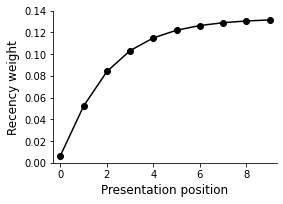

In [33]:
fig = plt.figure(figsize=(4, 2.8))

x = np.linspace(0, 9, 10)
plt.plot(x, recency(x, tau=2, eps=0.05) / sum(recency(x, tau=2, eps=0.05)), 'ko-')
plt.xlabel('Presentation position', fontsize=12)
plt.ylabel('Recency weight', fontsize=12)
plt.ylim([0, 0.14])
plt.xlim([-0.3, 9.3])
sns.despine(top=True, right=True)

fig.savefig(os.path.join(figdir, 'recency_weights.pdf'), bbox_inches='tight')

# Figure S5A

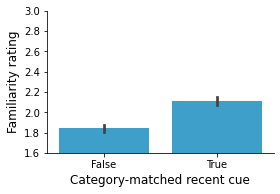

In [34]:
fig = plt.figure(figsize=(4, 2.8))
sns.barplot(sustained.query('`Trial Type` == "Memory" and Attention == "Novel"'), x='Category-matched recent cue', y='Familiarity Rating', color=attention_colors['Novel'])
plt.xlabel('Category-matched recent cue', fontsize=12)
plt.ylabel('Familiarity rating', fontsize=12)
plt.ylim([1.6, 3])
plt.tight_layout()
sns.despine(top=True, right=True)

# statistical test
vals = sustained.query('`Trial Type` == "Memory" and Attention == "Novel"').groupby(['Subject', 'Category-matched recent cue']).mean(numeric_only=True).reset_index().set_index('Subject')[['Category-matched recent cue', 'Familiarity Rating']].dropna(how='any', axis=0)

fig.savefig(os.path.join(figdir, 'sustained_category_match_recent_cue.pdf'), bbox_inches='tight')

In [35]:
result = ttest_rel(vals.query('`Category-matched recent cue` == True')['Familiarity Rating'], vals.query('`Category-matched recent cue` == False')['Familiarity Rating'])
if result.pvalue < 0.001:
    p_string = 'p < 0.001'
else:
    p_string = f'p = {result.pvalue:.3f}'
print(f'Response bias (increase in familiarity for novel images from the most recently cued category): $t({result.df}) = {result.statistic:.3f}, {p_string}$')

Response bias (increase in familiarity for novel images from the most recently cued category): $t(29) = 4.371, p < 0.001$


In [36]:
def cue_recency_heatmaps(df, metrics=None, fname=None):

    attention_levels = ['Attended', 'Attended category', 'Attended location', 'Unattended', 'Novel']

    if metrics is None:
        metrics = ['Distance to nearest same-category cue', 'Recency-weighted number of same-category cues']

    fig, ax = plt.subplots(nrows=len(metrics), ncols=len(attention_levels), figsize=(15, 6), sharey=True, sharex='row')
    x = df.query('`Trial Type` == "Memory"')

    for j, c in enumerate(metrics):
        for i, a in enumerate(attention_levels):
            xa = x.query('Attention == @a').sort_values(by=[c])

            if xa.shape[0] == 0:
                ax[j, i].set_axis_off()
                continue

            if c == 'Recency-weighted number of same-category cues':
                bins = np.histogram(xa[c], bins=25)[1]
                xa['Digitized recency-weighted number of same-category cues'] = np.digitize(xa[c], bins)
                cx = 'Digitized recency-weighted number of same-category cues'
                vmax = 0.025
            else:
                vmax = 0.15
                cx = c


            sns.histplot(data=xa, x=cx, y='Familiarity Rating', discrete=True, cmap=sns.light_palette(attention_colors[a], as_cmap=True), stat='probability', vmin=0, vmax=vmax, common_norm=True, cbar=False, ax=ax[j, i])
            sns.regplot(data=xa, x=cx, y='Familiarity Rating', color='k', scatter=False, ax=ax[j, i])
            ax[j, i].set_xlabel(c.replace('same-', '\nsame-'), fontsize=12)

            if j == 0:
                ax[j, i].set_title(a, fontsize=14)
            if i == 0:
                ax[j, i].set_ylabel('Familiarity rating', fontsize=12)
            else:
                ax[j, i].set_ylabel('')
            
            ax[j, i].set_yticks([1, 2, 3, 4])

            ax[j, i].set_xlim([0.5, xa[cx].max() + 0.5])
            ax[j, i].set_ylim([0.5, 4.5])                                                

            vals = xa[['Familiarity Rating', c]].dropna(how='any', axis=0)
            r = pearsonr(vals[c], vals['Familiarity Rating'])
            if r.pvalue < 0.001:
                p_string = 'p < 0.001'
            else:
                p_string = f'p = {r.pvalue:.3f}'

            print(f'{a} {c} $r = {r.statistic:.3f}, {p_string}$')

    plt.tight_layout()

    # fix up recency-weighted labels
    for j, c in enumerate(metrics):
        if c == 'Recency-weighted number of same-category cues':
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")  # ignore FixedLocator warning
                ax[j, 0].set_xticklabels([f'{bins[int(i) - 1] + bins[int(i)] / 2:0.2f}' if (i > 1 and i < len(bins)) else '' for i in ax[j, 0].get_xticks()])

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

# Figure S5B

Attended Distance to nearest same-category cue $r = -0.001, p = 0.982$
Attended category Distance to nearest same-category cue $r = 0.034, p = 0.315$
Attended location Distance to nearest same-category cue $r = 0.038, p = 0.254$
Unattended Distance to nearest same-category cue $r = -0.044, p = 0.189$
Novel Distance to nearest same-category cue $r = -0.029, p = 0.085$
Attended Recency-weighted number of same-category cues $r = -0.008, p = 0.810$
Attended category Recency-weighted number of same-category cues $r = 0.044, p = 0.190$
Attended location Recency-weighted number of same-category cues $r = 0.069, p = 0.041$
Unattended Recency-weighted number of same-category cues $r = -0.061, p = 0.069$
Novel Recency-weighted number of same-category cues $r = -0.027, p = 0.107$


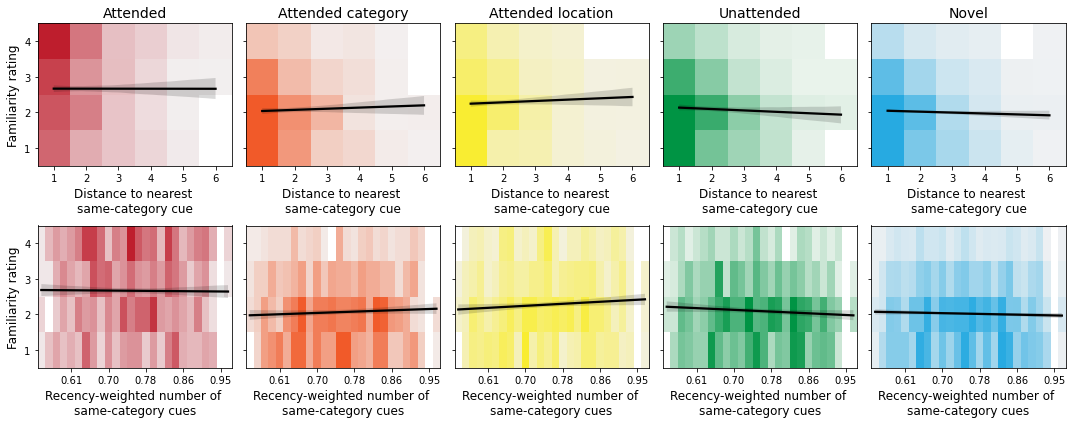

In [37]:
cue_recency_heatmaps(variable, fname='cue_recency_heatmaps_variable');